# Objective

The goal is to qualitatively identify the customer's opinion on mobile phones using Machine Learning applied on dataset that was compiled using web scrapping from 91mobiles.com website.

Kaggle Competition involves deducing the ratings to Like/DisLike predictions on a chosen rating threshold converting this into a binary classification problem with respect to mobile data.

Mobile Data Source: https://www.91mobiles.com/

In short,

**Task: To predict whether the user likes the mobile phone or not.** 

**Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt;plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
from sklearn import preprocessing
import operator
import json
from IPython import display
import os
import warnings
import seaborn as sns
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 200)
np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

In [2]:
# read data from file
train = pd.read_csv("../input/padhai-perceptron-like-unlike-classification/train.csv") 
test = pd.read_csv("../input/padhai-perceptron-like-unlike-classification/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


# Exploratory Data Analysis (relevant to current Mobile data)

The purpose of this EDA is to find insights which will serve us later in another notebook for Data cleaning/preparation/transformation which will ultimately be used into a machine learning algorithm.
We will proceed as follow:

<img src="http://sharpsightlabs.com/wp-content/uploads/2016/05/1_data-analysis-for-ML_how-we-use-dataAnalysis_2016-05-16.png" />

[Source](http://sharpsightlabs.com/blog/data-analysis-machine-learning-example-1/)

Where each steps (Data exploration, Data cleaning, Model building, Presenting results)

From these informations we can already see that some features won't be relevant in our exploratory analysis as there are too much missing values Plus there is so 
With so many features to analyse that it may be diffciutl to understand everyhtigh. We try to trim down our data sequentialy. may be better to concentrate on the ones which can give us real insights. Let's just remove list out features with 30% or less `NaN` values on a new dummy dataframe of train/test dataset.

In [3]:
df = pd.read_csv("../input/padhai-perceptron-like-unlike-classification/train.csv") 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 99 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   PhoneId                                      355 non-null    int64  
 1   Also Known As                                17 non-null     object 
 2   Applications                                 43 non-null     object 
 3   Architecture                                 273 non-null    object 
 4   Aspect Ratio                                 204 non-null    object 
 5   Audio Features                               30 non-null     object 
 6   Audio Jack                                   343 non-null    object 
 7   Autofocus                                    333 non-null    object 
 8   Bezel-less display                           154 non-null    object 
 9   Bluetooth                                    351 non-null    object 
 10  Br

In [4]:
# df.count() does not include NaN values
#Setting a 30% threshild for finding missing value features
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c)
print('\n')
df = df2
df.head()


List of dropped columns: Also Known As
Applications
Audio Features
Browser
Build Material
Co-Processor
Display Colour
Email
Games
HDMI
Heart Rate Monitor
IRIS Scanner
Java
Mobile High-Definition Link(MHL)
Music
Other Facilities
Phone Book
Ring Tone
Ruggedness
SIM 3
SMS
Screen to Body Ratio (claimed by the brand)
Software Based Aperture
Special Features
Stylus
USB Type-C
Video Player
Video Recording Features
Waterproof
Wireless Charging




,PhoneId,Architecture,Aspect Ratio,Audio Jack,Autofocus,Bezel-less display,Bluetooth,Brand,Camera Features,Capacity,Chipset,Colours,Custom UI,Display Type,Expandable Memory,FM Radio,Fingerprint Sensor,Fingerprint Sensor Position,Flash,GPS,Graphics,Height,Image Resolution,Internal Memory,Launch Date,Loudspeaker,Model,NFC,Network,Network Support,Operating System,Optical Image Stabilisation,Other Sensors,Physical Aperture,Pixel Density,Processor,Quick Charging,RAM,Rating Count,Resolution,Review Count,SAR Value,SIM 1,SIM 2,SIM Size,SIM Slot(s),Screen Protection,Screen Resolution,Screen Size,Screen to Body Ratio (calculated),Sensor,Settings,Shooting Modes,Standby time,TalkTime,Thickness,Touch Screen,Type,USB Connectivity,USB OTG Support,User Available Storage,User Replaceable,Video Recording,VoLTE,Weight,Wi-Fi,Wi-Fi Features,Width,Rating
0,0,64 bit,19:9,3.5 mm,Phase Detection autofocus,yes,v5.0,Xiaomi,"Digital Zoom, Auto Flash, Face detection, Touc...",4000 mAh,Qualcomm Snapdragon 636,"Black, Blue, Red, Rose Gold",MIUI,IPS LCD,Up to 256 GB,NaN,yes,Rear,Dual-color LED Flash,"with A-GPS, Glonass",Adreno 509,157.9 mm Compare Size,4000 x 3000 Pixels,64 GB Best in Class ▾Internal Memory compared ...,"November 23, 2018 (Official)",yes,Redmi Note 6 Pro,NaN,4G: Available (supports Indian bands) 3G: Avai...,"4G (supports Indian bands), 3G, 2G",Android v8.1 (Oreo),NaN,"Light sensor, Proximity sensor, Accelerometer,...",F2.0,403 ppi Best in Class ▾Pixel Density compared ...,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...","Quick, v3.0",4 GB Excellent ▾RAM compared to11 - 17 K Phone...,172274,20 MP + 2 MP Dual Front Cameras Best in Class ...,17138,NaN,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,4G Bands: TD-LTE 2300(band 40) / 2500(band 41)...,"SIM1: Nano, SIM2: Nano (Hybrid)","Dual SIM, GSM+GSM, Dual VoLTE",Corning Gorilla Glass,1080 x 2280 pixels,6.26 inches (15.9 cm),80.68 %,Exmor RS,"Exposure compensation, ISO control","Continuos Shooting, High Dynamic Range mode (H...",NaN,NaN,8.2 mm Very Good ▾Thickness compared to11 - 17...,"Capacitive Touchscreen, Multi-touch",Li-Polymer,"Mass storage device, USB charging, microUSB 2.0",yes,Up to 52.3 GB,No,1920x1080 @ 30 fps,yes,182 grams Below Average ▾Weight compared to11 ...,"Wi-Fi 802.11, a/b/g/n","Wi-Fi Direct, Mobile Hotspot",76.4 mm,4.5
1,1,64 bit,19:9,3.5 mm,Phase Detection autofocus,yes,v4.2,Realme,"2 x Digital Zoom, Auto Flash, Face detection, ...",4230 mAh,Qualcomm Snapdragon 450,"Diamond Black, Diamond Blue, Diamond Red",ColorOS,IPS LCD,Up to 256 GB,NaN,yes,Rear,LED Flash,with A-GPS,Adreno 506,156.2 mm Compare Size,4128 x 3096 Pixels,32 GB Excellent ▾Internal Memory compared to8 ...,"September 4, 2018 (Official)",yes,2,No,4G: Available (supports Indian bands) 3G: Avai...,"4G (supports Indian bands), 3G, 2G",Android v8.1 (Oreo),NaN,"Light sensor, Proximity sensor, Accelerometer,...",F2.2,271 ppi Good ▾Pixel Density compared to8 - 12 ...,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",No,3 GB Excellent ▾RAM compared to8 - 12 K Phones...,339447,8 MP Front Camera Very Good ▾Front Camera comp...,38252,NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,"SIM1: Nano, SIM2: Nano","Dual SIM, GSM+GSM, Dual VoLTE",Corning Gorilla Glass v3,720 x 1520 pixels,6.2 inches (15.75 cm),80.85 %,NaN,"Exposure compensation, ISO control","Continuos Shooting, High Dynamic Range mode (HDR)",NaN,Up to 44 Hours(2G),8.2 mm Very Good ▾Thickness compared to8 - 12 ...,"Capacitive Touchscreen, Multi-touch",Li-ion,"Mass storage device, USB charging, microUSB 2.0",yes,Up to 23.2 GB,No,1920x1080 @ 30 fps,yes,168 grams Average ▾Weight compared to8 - 12 K ...,"Wi-Fi 802.11, b/g/n",Mobile Hotspot,75.6 mm,4.5
2,2,64 bit,19.5:9,3.5 mm,yes,yes,v4.2,Realme,"2 x Digital Zoom, Auto Flash, Face detection, ...",3500 mAh,MediaTek Helio P70,"Brave Blue, Fiery Gold, Ambitious Black",ColorOS,IPS LCD,Up to 256 GB,yes,yes,Rear,LED Flash,"with A-GPS, Glonass",Mali-G72 MP3,157 m

In [5]:
#Check if Dates make any sense, or do they hold any patterns
print(df[['Rating','Launch Date']])

     Rating                    Launch Date
0       4.5   November 23, 2018 (Official)
1       4.5   September 4, 2018 (Official)
2       4.4    December 5, 2018 (Official)
3       4.3  September 27, 2018 (Official)
4       4.4    October 24, 2018 (Official)
5       4.4                            NaN
6       4.5  September 12, 2018 (Official)
7       4.3  September 19, 2018 (Official)
8       4.1  September 11, 2018 (Official)
9       4.3       July 15, 2018 (Official)
10      4.5     August 29, 2018 (Official)
11      4.5    November 1, 2018 (Official)
12      4.0     August 16, 2018 (Official)
13      4.4       July 31, 2018 (Official)
14      4.4       April 2, 2018 (Official)
15      4.4   December 21, 2018 (Official)
16      4.4     August 30, 2018 (Official)
17      4.5   December 20, 2018 (Official)
18      4.4   November 25, 2018 (Official)
19      4.4      August 6, 2018 (Official)
20      4.4   December 20, 2018 (Official)
21      4.4   November 27, 2018 (Official)
22      4.5

In [6]:
test.head()

,PhoneId,Also Known As,Applications,Architecture,Aspect Ratio,Audio Features,Audio Jack,Autofocus,Bezel-less display,Bluetooth,Brand,Browser,Build Material,Camera Features,Capacity,Chipset,Co-Processor,Colours,Custom UI,Display Colour,Display Type,Email,Expandable Memory,FM Radio,Fingerprint Sensor,Fingerprint Sensor Position,Flash,GPS,Games,Graphics,HDMI,Heart Rate Monitor,Height,IRIS Scanner,Image Resolution,Internal Memory,Java,Launch Date,Loudspeaker,Mobile High-Definition Link(MHL),Model,Music,NFC,Network,Network Support,Operating System,Optical Image Stabilisation,Other Facilities,Other Sensors,Phone Book,Physical Aperture,Pixel Density,Processor,Quick Charging,RAM,Rating Count,Resolution,Review Count,Ring Tone,Ruggedness,SAR Value,SIM 1,SIM 2,SIM 3,SIM Size,SIM Slot(s),SMS,Screen Protection,Screen Resolution,Screen Size,Screen to Body Ratio (calculated),Screen to Body Ratio (claimed by the brand),Sensor,Settings,Shooting Modes,Software Based Aperture,Special Features,Standby time,Stylus,TalkTime,Thickness,Touch Screen,Type,USB Connectivity,USB OTG Support,USB Type-C,User Available Storage,User Replaceable,Video Player,Video Recording,Video Recording Features,VoLTE,Waterproof,Weight,Wi-Fi,Wi-Fi Features,Width,Wireless Charging
0,3,NaN,NaN,64 bit,19:9,NaN,3.5 mm,Phase Detection autofocus,yes,v4.2,Realme,NaN,NaN,"Digital Zoom, Auto Flash, Face detection, Touc...",4230 mAh,Qualcomm Snapdragon 450,NaN,"Black, Blue",ColorOS,NaN,IPS LCD,NaN,Up to 256 GB,yes,No,NaN,LED Flash,with A-GPS,NaN,Adreno 506,NaN,NaN,156.2 mm Compare Size,NaN,4128 x 3096 Pixels,16 GB Very Good ▾Internal Memory compared to6 ...,NaN,"October 11, 2018 (Official)",yes,NaN,C1,NaN,No,4G: Available (supports Indian bands) 3G: Avai...,"4G (supports Indian bands), 3G, 2G",Android v8.1 (Oreo),NaN,NaN,"Light sensor, Proximity sensor, Accelerometer,...",NaN,F2.2,271 ppi Good ▾Pixel Density compared to6 - 8 K...,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",NaN,2 GB Very Good ▾RAM compared to6 - 8 K PhonesA...,177067,5 MP Front Camera Average ▾Front Camera compar...,20529,NaN,NaN,NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,NaN,"SIM1: Nano, SIM2: Nano","Dual SIM, GSM+GSM, Dual VoLTE",NaN,Corning Gorilla Glass,720 x 1520 pixels,6.2 inches (15.75 cm),80.85 %,NaN,NaN,"Exposure compensation, ISO control","Continuos Shooting, High Dynamic Range mode (HDR)",NaN,NaN,NaN,NaN,NaN,8.2 mm Very Good ▾Thickness compared to6 - 8 K...,"Capacitive Touchscreen, Multi-touch",Li-ion,"Mass storage device, USB charging, microUSB 2.0",yes,NaN,Up to 8.67 GB,No,NaN,1920x1080 @ 30 fps,NaN,yes,NaN,168 grams Average ▾Weight compared to6 - 8 K P...,"Wi-Fi 802.11, b/g/n",Mobile Hotspot,75.6 mm,NaN
1,11,NaN,NaN,64 bit,19:9,NaN,3.5 mm,Phase Detection autofocus,yes,v5.0,Motorola,NaN,NaN,"Digital Zoom, Auto Flash, Face detection, Touc...",5000 mAh,Qualcomm Snapdragon 636,NaN,Black,Android One,NaN,IPS LCD,NaN,Up to 256 GB,yes,yes,Rear,LED Flash,"with A-GPS, Glonass",NaN,Adreno 509,NaN,NaN,156 mm Compare Size,NaN,4616 x 3464 Pixels,64 GB Best in Class ▾Internal Memory compared ...,NaN,"October 5, 2018 (Official)",yes,NaN,One Power,NaN,No,4G: Available (supports Indian bands) 3G: Avai...,"4G (supports Indian bands), 3G, 2G",Android v8.1 (Oreo),NaN,NaN,"Light sensor, Proximity sensor, Accelerometer,...",NaN,F2.0,402 ppi Best in Class ▾Pixel Density compared ...,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",Turbo,4 GB Excellent ▾RAM compared to12 - 18 K Phone...,50300,12 MP Front Camera Very Good ▾Front Camera com...,7883,NaN,NaN,NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,NaN,"SIM1: Nano, SIM2: Nano","Dual SIM, GSM+GSM, Dual VoLTE",NaN,Corning Gorilla Glass,1080 x 2246 pixels,6.2 inches (15.75 cm),81.6 %,NaN,NaN,ISO control,"Continuos Shooting, High Dynamic Range mode (HDR)",NaN,NaN,NaN,NaN,NaN,8.9 mm Good ▾Thickness compared to12 - 18 K Ph...,"Capacitive Touchscreen, Multi

In [7]:
train.head()

,PhoneId,Also Known As,Applications,Architecture,Aspect Ratio,Audio Features,Audio Jack,Autofocus,Bezel-less display,Bluetooth,Brand,Browser,Build Material,Camera Features,Capacity,Chipset,Co-Processor,Colours,Custom UI,Display Colour,Display Type,Email,Expandable Memory,FM Radio,Fingerprint Sensor,Fingerprint Sensor Position,Flash,GPS,Games,Graphics,HDMI,Heart Rate Monitor,Height,IRIS Scanner,Image Resolution,Internal Memory,Java,Launch Date,Loudspeaker,Mobile High-Definition Link(MHL),Model,Music,NFC,Network,Network Support,Operating System,Optical Image Stabilisation,Other Facilities,Other Sensors,Phone Book,Physical Aperture,Pixel Density,Processor,Quick Charging,RAM,Rating Count,Resolution,Review Count,Ring Tone,Ruggedness,SAR Value,SIM 1,SIM 2,SIM 3,SIM Size,SIM Slot(s),SMS,Screen Protection,Screen Resolution,Screen Size,Screen to Body Ratio (calculated),Screen to Body Ratio (claimed by the brand),Sensor,Settings,Shooting Modes,Software Based Aperture,Special Features,Standby time,Stylus,TalkTime,Thickness,Touch Screen,Type,USB Connectivity,USB OTG Support,USB Type-C,User Available Storage,User Replaceable,Video Player,Video Recording,Video Recording Features,VoLTE,Waterproof,Weight,Wi-Fi,Wi-Fi Features,Width,Wireless Charging,Rating
0,0,NaN,NaN,64 bit,19:9,NaN,3.5 mm,Phase Detection autofocus,yes,v5.0,Xiaomi,NaN,NaN,"Digital Zoom, Auto Flash, Face detection, Touc...",4000 mAh,Qualcomm Snapdragon 636,NaN,"Black, Blue, Red, Rose Gold",MIUI,NaN,IPS LCD,NaN,Up to 256 GB,NaN,yes,Rear,Dual-color LED Flash,"with A-GPS, Glonass",NaN,Adreno 509,NaN,NaN,157.9 mm Compare Size,NaN,4000 x 3000 Pixels,64 GB Best in Class ▾Internal Memory compared ...,NaN,"November 23, 2018 (Official)",yes,NaN,Redmi Note 6 Pro,NaN,NaN,4G: Available (supports Indian bands) 3G: Avai...,"4G (supports Indian bands), 3G, 2G",Android v8.1 (Oreo),NaN,NaN,"Light sensor, Proximity sensor, Accelerometer,...",NaN,F2.0,403 ppi Best in Class ▾Pixel Density compared ...,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...","Quick, v3.0",4 GB Excellent ▾RAM compared to11 - 17 K Phone...,172274,20 MP + 2 MP Dual Front Cameras Best in Class ...,17138,NaN,NaN,NaN,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,4G Bands: TD-LTE 2300(band 40) / 2500(band 41)...,NaN,"SIM1: Nano, SIM2: Nano (Hybrid)","Dual SIM, GSM+GSM, Dual VoLTE",NaN,Corning Gorilla Glass,1080 x 2280 pixels,6.26 inches (15.9 cm),80.68 %,NaN,Exmor RS,"Exposure compensation, ISO control","Continuos Shooting, High Dynamic Range mode (H...",NaN,NaN,NaN,NaN,NaN,8.2 mm Very Good ▾Thickness compared to11 - 17...,"Capacitive Touchscreen, Multi-touch",Li-Polymer,"Mass storage device, USB charging, microUSB 2.0",yes,NaN,Up to 52.3 GB,No,NaN,1920x1080 @ 30 fps,NaN,yes,NaN,182 grams Below Average ▾Weight compared to11 ...,"Wi-Fi 802.11, a/b/g/n","Wi-Fi Direct, Mobile Hotspot",76.4 mm,NaN,4.5
1,1,NaN,Oppo Browser,64 bit,19:9,NaN,3.5 mm,Phase Detection autofocus,yes,v4.2,Realme,NaN,NaN,"2 x Digital Zoom, Auto Flash, Face detection, ...",4230 mAh,Qualcomm Snapdragon 450,NaN,"Diamond Black, Diamond Blue, Diamond Red",ColorOS,NaN,IPS LCD,NaN,Up to 256 GB,NaN,yes,Rear,LED Flash,with A-GPS,NaN,Adreno 506,NaN,NaN,156.2 mm Compare Size,NaN,4128 x 3096 Pixels,32 GB Excellent ▾Internal Memory compared to8 ...,NaN,"September 4, 2018 (Official)",yes,NaN,2,NaN,No,4G: Available (supports Indian bands) 3G: Avai...,"4G (supports Indian bands), 3G, 2G",Android v8.1 (Oreo),NaN,NaN,"Light sensor, Proximity sensor, Accelerometer,...",NaN,F2.2,271 ppi Good ▾Pixel Density compared to8 - 12 ...,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",No,3 GB Excellent ▾RAM compared to8 - 12 K Phones...,339447,8 MP Front Camera Very Good ▾Front Camera comp...,38252,NaN,NaN,NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,NaN,"SIM1: Nano, SIM2: Nano","Dual SIM, GSM+GSM, Dual VoLTE",NaN,Corning Gorilla Glass v3,720 x 1520 pixels,6.2 inches (15.75 cm),80.85 %,88.8 %,NaN,"Exposure compensation, 

In [8]:
train.describe()
#Probably works only for numerical data

,PhoneId,Rating Count,Review Count,Rating
count,355.000000,3.550000e+02,355.000000,355.000000
mean,235.267606,3.344979e+04,6648.228169,4.071549
std,137.204594,1.151661e+05,18943.317868,0.372663
min,0.000000,1.000000e+00,1.000000,2.500000
25%,113.500000,6.585000e+02,228.000000,3.900000
50%,234.000000,3.744000e+03,951.000000,4.100000
75%,358.000000,1.613650e+04,4208.500000,4.300000
max,472.000000,1.268083e+06,218020.000000,5.000000


Just the first look from data tells us it has lot of different data types involved. If we want to train models that can't handle categorical data, we need to convert the data into categorical values and implement one hot encoding. All there are a lot of Missing Values. Honsetly, its a very messy dataset.

Also since I am assuming the dataset to not have any wrong/faulty measurement of data points (Might be true mostly but not sure). I am deciding to not go ahead with outlier removal. to support my hypothesis, take the example of Capacity, most of the phones of have average to medium range battery size. But there exists phones (probably from China) that will give us enormous battery sizes. Or consider the number of reviews for each phone to strengthen this argument.

Data Cleaning (using Analytical methods and proir domain knowledge)
Painstakingly going through data to remove redudant/messy/missing value features.

* High Correlation:

    *     'SIM Slot(s)' high correlation with SIM1 
    *     'Weight' has high high correlation with capacity 
    *     'Height' and screen size are repetitive
    
* Missing values:

'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

* Low Variance:

    *     'Architecture'(most entries are 64-bit)
    *     'Audio Jack'
    *     'GPS'
    *     'Loudspeaker'
    *     'Network'
    *     'Network Support'
    *     'Other Sensors'(28)
    *     'SIM Size'
    *     'VoLTE'
    
* Multivalued (and also noisy and not useful in decision making/data modelling):

    * 'Colours'
    * 'Custom UI'
    * 'Model'(1)
    * 'Other Sensors'
    * 'Launch Date'
    * 'Bluetooth'
    * 'Settings'(75)
    * 'Wi-Fi'
    * 'Wi-Fi Features'
    
    
*     Check analytically:
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing), 'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity', 'Display Type','Expandable Memory','FM Radio'

* Retained Features (or final features):

'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


**The choice to remove many features is motivated from the avaialable dataset size. Since we only have ~350 training examples, It doesn't make sense to have 100 features (columns). Finally I have reduced the given 97 features (excluding input and output) to 47 features.**

# Extensive Data Cleaning

## Removing features

In [9]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

In [10]:
train = data_clean(train)
test = data_clean(test)

### **Removing all those data points in which more than 15 features are missing **

In [11]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [12]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Imputing Missing values

In [13]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [14]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [15]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


# **Remove not very important/useful feature**

In [16]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [17]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [18]:
train

,Height,os_name,SIM 2,Internal Memory,Num_cores,Brand,Screen Size,Resolution,PhoneId,Capacity,Screen to Body Ratio (calculated),RAM,Weight,Rating,Pixel Density,Sim1,SIM Slot(s),Processor_frequency
0,157.900000,Android,4G,64,Octa,Xiaomi,6.26,20,0,4000,80.68,4,182,4.5,403,4G,"Dual SIM, GSM+GSM, Dual VoLTE",1.80
1,156.200000,Android,4G,32,Octa,Realme,6.20,8,1,4230,80.85,3,168,4.5,271,4G,"Dual SIM, GSM+GSM, Dual VoLTE",1.80
2,157.000000,Android,4G,32,Octa,Realme,6.30,25,2,3500,83.68,3,168,4.4,409,4G,"Dual SIM, GSM+GSM, Dual VoLTE",2.10
3,159.800000,Android,4G,64,Octa,Samsung,6.00,24,4,3300,74.78,4,169,4.3,411,4G,"Dual SIM, GSM+GSM",2.20
4,160.400000,Android,4G,64,Octa,Honor,6.50,16,5,3750,84.23,4,175,4.4,396,4G,"Dual SIM, GSM+GSM, Dual VoLTE",2.20
6,157.900000,Android,4G,64,Octa,Vivo,6.41,25,7,3400,84.98,6,156,4.5,402,4G,"Dual SIM, GSM+GSM, Dual VoLTE",2.20
7,147.500000,Android,4G,16,Quad,Xiaomi,5.45,5,8,3000,72.68,2,145,4.3,295,4G,"Dual SIM, GSM+GSM, Dual VoLTE",2.00
8,149.300000,Android,4G,32,Octa,Xiaomi,5.84,5,9,4000,79.24,3,178,4.1,432,4G,"Dual SIM, GSM+GSM",2.00
9,156.200000,Android,4G,16,Octa,OPPO,6.20,8,10,4230,80.85,2,168,4.3,271,4G,"Dual SIM, GSM+GSM",1.80
10,155.500000,Android,4G,64,Octa,Xiaomi Poco,6.18,20,12,4000,82.20,6,182,4.5,403,4G,"Dual SIM, GSM+GSM, Dual VoLTE",2.80


In [19]:
# one hot encoding
train_ids = df['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]







(460, 17)
Index(['PhoneId', 'Height', 'os_name', 'SIM 2', 'Internal Memory', 'Num_cores',
       'Brand', 'Screen Size', 'Resolution', 'Capacity',
       'Screen to Body Ratio (calculated)', 'RAM', 'Weight', 'Pixel Density',
       'Sim1', 'SIM Slot(s)', 'Processor_frequency'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Height', 'Internal Memory', 'Screen Size', 'Resolution',
       'Capacity', 'Screen to Body Ratio (calculated)', 'RAM', 'Weight',
       'Pixel Density', 'Processor_frequency', 'os_name_Android',
       'os_name_Blackberry', 'os_name_KAI', 'os_name_Nokia', 'os_name_Other',
       'os_name_Tizen', 'os_name_iOS', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G',
       'SIM 2_Other', 'Num_cores_312', 'Num_cores_Deca', 'Num_cores_Dual',
       'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other', 'Num_cores_Quad',
       'Num_cores_Tru-Octa', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus',
       'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad',
       'Brand_Do'

In [20]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Height', 'os_name', 'SIM 2', 'Internal Memory', 'Num_cores',
       'Brand', 'Screen Size', 'Resolution', 'Capacity',
       'Screen to Body Ratio (calculated)', 'RAM', 'Weight', 'Pixel Density',
       'Sim1', 'SIM Slot(s)', 'Processor_frequency'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Height', 'Internal Memory', 'Screen Size', 'Resolution',
       'Capacity', 'Screen to Body Ratio (calculated)', 'RAM', 'Weight',
       'Pixel Density', 'Processor_frequency', 'os_name_Android',
       'os_name_Blackberry', 'os_name_KAI', 'os_name_Nokia', 'os_name_Other',
       'os_name_Tizen', 'os_name_iOS', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G',
       'SIM 2_Other', 'Num_cores_312', 'Num_cores_Deca', 'Num_cores_Dual',
       'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other', 'Num_cores_Quad',
       'Num_cores_Tru-Octa', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus',
       'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad',
       'Brand_Do'

In [21]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [22]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


# My Analysis

In [23]:
train_new

,PhoneId,Height,Internal Memory,Screen Size,Resolution,Capacity,Screen to Body Ratio (calculated),RAM,Weight,Pixel Density,Processor_frequency,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Sim1_2G,Sim1_3G,Sim1_4G,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Rating
0,0,157.900000,64,6.26,20,4000,80.68,4,182,403,1.80,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,4.5
1,1,156.200000,32,6.20,8,4230,80.85,3,168,271,1.80,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,4.5
2,2,157.000000,32,6.30,25,3500,83.68,3,168,409,2.10,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,4.4
3,4,159.800000,64,6.00,24,3300,74.78,4,169,411,2.20,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,4.3
4,5,160.400000,64,6.50,16,3750,84.23,4,175,396,2.20,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,4.4
5,7,157.900000,64,6.41,25,3400,84.98,6,156,402,2.20,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,4.5
6,8,147.500000,16,5.45,5,3000,72.68,2,145,295,2.00,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,4.3
7,9,149.300000,32,5.84,5,4000,79.24,3,178,432,2.00,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,4.1
8,10,156.200000,16,6.20,8,4230,80.85,2,168,271,1.80,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,4.3
9,12,155.500000,64,6.18,20,4000,82.20,6,182,403,2.80,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,4.5


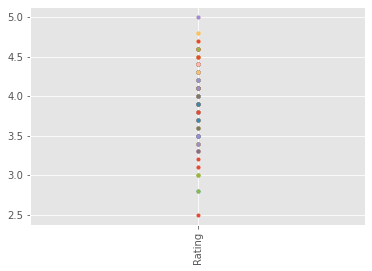

Mean:  4.072434017595307 
Median 4.1


In [24]:
#Doing this to select the right threshold value for Like/Dislike Rating Segmentation
plt.plot(train_new[['Rating']].T,'.'); plt.grid(True);
plt.xticks(rotation='vertical');plt.show()
train_new['Rating'].describe()
print('Mean: ',train_new['Rating'].mean(),'\nMedian',train_new['Rating'].median())

Clearly Mean and Median are close to the range(4,4.1). So binarization threshold should be in this range. We can experiment here to play with test accuracy if necessary

# Binarization & Further Data Preprocessing

In [25]:
train_new.describe()

,PhoneId,Height,Internal Memory,Screen Size,Resolution,Capacity,Screen to Body Ratio (calculated),RAM,Weight,Pixel Density,Processor_frequency,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Sim1_2G,Sim1_3G,Sim1_4G,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Rating
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,232.970674,149.946394,46.369501,5.462317,9.592375,3191.307918,72.353343,11.120235,161.343109,344.211144,1.792551,0.906158,0.005865,0.005865,0.002933,0.020528,0.002933,0.055718,0.211144,0.020528,0.683284,0.085044,0.002933,0.005865,0.029326,0.035191,0.580645,0.017595,0.325513,0.002933,0.005865,0.055718,0.023460,0.0,0.014663,0.002933,0.005865,0.0,0.029326,0.011730,0.017595,0.049853,0.017595,0.008798,0.008798,0.011730,0.011730,0.002933,0.005865,0.026393,0.017595,0.002933,0.043988,0.002933,0.002933,0.005865,0.043988,0.011730,0.043988,0.005865,0.061584,0.002933,0.041056,0.008798,0.017595,0.011730,0.002933,0.011730,0.002933,0.129032,0.026393,0.0,0.023460,0.002933,0.002933,0.076246,0.061584,0.008798,0.011730,0.002933,0.020528,0.020528,0.958944,0.002933,0.759531,0.152493,0.085044,4.072434
std,137.231746,9.192305,46.435453,0.742529,5.953827,932.533527,9.357839,61.320855,22.305556,88.161129,0.451598,0.292037,0.076471,0.076471,0.054153,0.142006,0.054153,0.229714,0.408720,0.142006,0.465879,0.279357,0.054153,0.076471,0.168965,0.184532,0.494179,0.131668,0.469255,0.054153,0.076471,0.229714,0.151583,0.0,0.120375,0.054153,0.076471,0.0,0.168965,0.107827,0.131668,0.217962,0.131668,0.093520,0.093520,0.107827,0.107827,0.054153,0.076471,0.160536,0.131668,0.054153,0.205370,0.054153,0.054153,0.076471,0.205370,0.107827,0.205370,0.076471,0.240751,0.054153,0.198711,0.093520,0.131668,0.107827,0.054153,0.107827,0.054153,0.335728,0.160536,0.0,0.151583,0.054153,0.054153,0.265782,0.240751,0.093520,0.107827,0.054153,0.142006,0.142006,0.198711,0.054153,0.427996,0.360026,0.279357,0.377066
min,0.000000,115.600000,0.000000,2.400000,2.000000,1020.000000,23.600000,1.000000,58.000000,143.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [26]:
train_new['Label'] = train_new['Rating'].apply(lambda x: 1 if (x>= 4) else 0)
train_new = train_new.drop(['Rating'],axis = 1)
train_new.groupby('Label').describe()

X_train = train_new;Y_train = X_train['Label'];X_train = X_train.drop(['Label'],axis = 1);X_train = X_train.drop(['PhoneId'],axis = 1)
X_test = test_new;X_test = X_test.drop(['PhoneId'],axis=1)
#Convert to numpy arrays
X_train = X_train.values;X_test = X_test.values
print(train_new.shape,X_train.shape,Y_train.shape,X_test.shape)

(341, 88) (341, 86) (341,) (119, 86)


In [27]:
#Normalizing Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#My data scaler
scaler = RobustScaler()
print("Printing Scaler on X_train to compute statistical metrics of the transform: ", scaler.fit(X_train))
# print("Scaler has computer this as the mean: ", scaler.mean_)

Printing Scaler on X_train to compute statistical metrics of the transform:  RobustScaler()


In [28]:
#Finally normalizing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print("X_train Normalized: \n", X_train)
print("X_test Normalized: \n",X_test)

X_train Normalized: 
 [[ 0.66        0.66666667  0.95       ... -1.          1.
   0.        ]
 [ 0.49        0.          0.875      ... -1.          1.
   0.        ]
 [ 0.57        0.          1.         ... -1.          1.
   0.        ]
 ...
 [-0.16       -0.33333333 -0.375      ...  0.          0.
   0.        ]
 [-1.93       -0.5        -1.25       ...  0.          0.
   0.        ]
 [-0.02        0.          0.         ...  0.          0.
   0.        ]]
X_test Normalized: 
 [[ 0.49       -0.33333333  0.875      ... -1.          1.
   0.        ]
 [ 0.47        0.66666667  0.875      ... -1.          1.
   0.        ]
 [ 0.54        0.66666667  1.         ... -1.          1.
   0.        ]
 ...
 [ 0.05       -0.5         0.         ...  0.          0.
   0.        ]
 [-0.21        0.         -0.375      ...  0.          0.
   0.        ]
 [-0.04        0.         -0.375      ... -1.          0.
   1.        ]]


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
print(X_train.shape,X_val.shape)

(306, 86) (35, 86)


# Machine Learning Models 

I try out different ensemble learning models along with SVM classifier 

In [30]:
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# clf_gbm = GradientBoostingClassifier(max_depth=3,n_estimators = 5000, learning_rate = 0.01, max_features = 'log2', subsample = 0.3, max_leaf_nodes= 3,random_state = 0)
clf_gbm = GradientBoostingClassifier(max_depth=3,n_estimators = 650, learning_rate = 0.01)
clf_gbm.fit(X_train,Y_train)
# print("GBM  - Training Accuracy: ", accuracy_score(clf_gbm.predict(X_train),Y_train))
# print(classification_report(clf_gbm.predict(X_train),Y_train))

clf_rf = RandomForestClassifier(max_depth=4, n_estimators = 120, oob_score = True, random_state=1)
clf_rf.fit(X_train,Y_train)
# print("Random Forest  - Training Accuracy: ", accuracy_score(clf_rf.predict(X_train),Y_train))
# print(classification_report(clf_rf.predict(X_train),Y_train))

from sklearn.ensemble import AdaBoostClassifier
clf_ab = AdaBoostClassifier(n_estimators= 50,learning_rate = 0.8, random_state=0)
clf_ab.fit(X_train,Y_train)
# print("AdaBoost - Training Accuracy: ", clf_ab.score(X_train,Y_train))
# print(classification_report(clf_ab.predict(X_train),Y_train))

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
clf_svm = make_pipeline(StandardScaler(), SVC(C = 2,gamma='auto'))
clf_svm.fit(X_train, Y_train)
# print("SVM - Training Accuracy: ", accuracy_score(clf_svm.predict(X_train),Y_train))
# print(classification_report(clf_svm.predict(X_train),Y_train))

#Validation Metrics
print("GBM  - Training Accuracy: ", accuracy_score(clf_gbm.predict(X_train),Y_train))
print("GBM - Validation Accuracy: ", accuracy_score(clf_gbm.predict(X_val),Y_val))
print(classification_report(clf_gbm.predict(X_val),Y_val))

print("Random Forest  - Training Accuracy: ", accuracy_score(clf_rf.predict(X_train),Y_train))
print("Random Forest  - Validation Accuracy: ", accuracy_score(clf_rf.predict(X_val),Y_val))
print(classification_report(clf_gbm.predict(X_val),Y_val))

print("AdaBoost - Training Accuracy: ", clf_ab.score(X_train,Y_train))
print("AdaBoost - Validation Accuracy: ", accuracy_score(clf_ab.predict(X_val),Y_val))
print(classification_report(clf_gbm.predict(X_val),Y_val))

print("SVM - Training Accuracy: ", accuracy_score(clf_svm.predict(X_train),Y_train))
print("SVM - Validation Accuracy: ", accuracy_score(clf_svm.predict(X_val),Y_val))
print(classification_report(clf_gbm.predict(X_val),Y_val))


GBM  - Training Accuracy:  0.9313725490196079
GBM - Validation Accuracy:  0.8857142857142857
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.96      0.90      0.93        29

    accuracy                           0.89        35
   macro avg       0.79      0.86      0.82        35
weighted avg       0.91      0.89      0.89        35

Random Forest  - Training Accuracy:  0.7647058823529411
Random Forest  - Validation Accuracy:  0.8
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.96      0.90      0.93        29

    accuracy                           0.89        35
   macro avg       0.79      0.86      0.82        35
weighted avg       0.91      0.89      0.89        35

AdaBoost - Training Accuracy:  0.9150326797385621
AdaBoost - Validation Accuracy:  0.7142857142857143
              precision    recall  f1-score   suppor

In [31]:
#Testing
Y_test = clf_gbm.predict(X_test)
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y_test})
submission = submission[['PhoneId', 'Class']]
submission.groupby(['Class']).describe()
submission
submission.to_csv("submission.csv", index=False)